Updating data.

YahooFinance update of AAPL is not append-only!
Difference between overlap of downloaded and stored:                            open  low  high  close   volume  return
2024-05-23 13:30:00+00:00   0.0  0.0   0.0    0.0  61000.0     0.0
2024-05-24 13:30:00+00:00   0.0  NaN   NaN    NaN      NaN     NaN


.

YahooFinance update of GOOG is not append-only!
Difference between overlap of downloaded and stored:                                open  low  high  close   volume    return
2024-05-23 13:30:00+00:00  0.000000  0.0   0.0    0.0  14400.0  0.000168
2024-05-24 13:30:00+00:00  0.029999  NaN   NaN    NaN      NaN       NaN
YahooFinance(GOOG) update changed last open price: stored value was 176.49000549316406, new value is 176.52000427246094



BUY AND HOLD

#################################################################
Universe size                                                   3
Initial timestamp                       2010-01-04 14:30:00+00:00
Final timestamp                         2023-12-29 14:30:00+00:00
Number of periods                                            3522
Initial value (JPYEN)                                   1.000e+04
Final value (JPYEN)                                     1.093e+06
Profit (JPYEN)                                          1.083e+06
                                                                 
Avg. return (annualized)                                    45.0%
Volatility (annualized)                                     47.9%
Avg. excess return (annualized)                             44.7%
Excess volatility (annualized)                              47.9%
                                                                 
Avg. growth rate (annualized)                               3

/Users/jacktang/miniconda3/envs/dev/lib/python3.11/site-packages/cvxportfolio/result.py:993: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show() # pragma: no cover


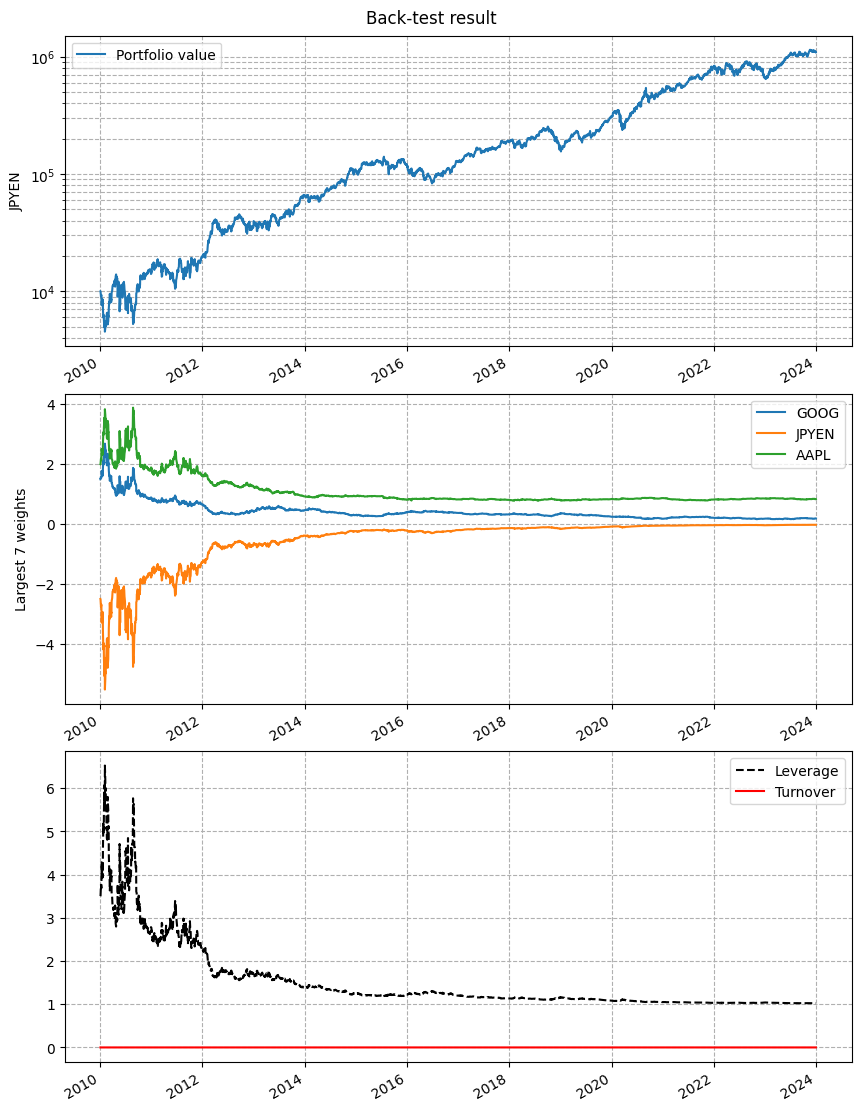

REBALANCE EVERY DAY

#################################################################
Universe size                                                   3
Initial timestamp                       2010-01-04 14:30:00+00:00
Final timestamp                         2023-12-29 14:30:00+00:00
Number of periods                                            3522
Initial value (JPYEN)                                   1.000e+04
Final value (JPYEN)                                     3.874e+06
Profit (JPYEN)                                          3.864e+06
                                                                 
Avg. return (annualized)                                    86.3%
Volatility (annualized)                                     92.6%
Avg. excess return (annualized)                             86.0%
Excess volatility (annualized)                              92.6%
                                                                 
Avg. growth rate (annualized)                          

/Users/jacktang/miniconda3/envs/dev/lib/python3.11/site-packages/cvxportfolio/result.py:993: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show() # pragma: no cover


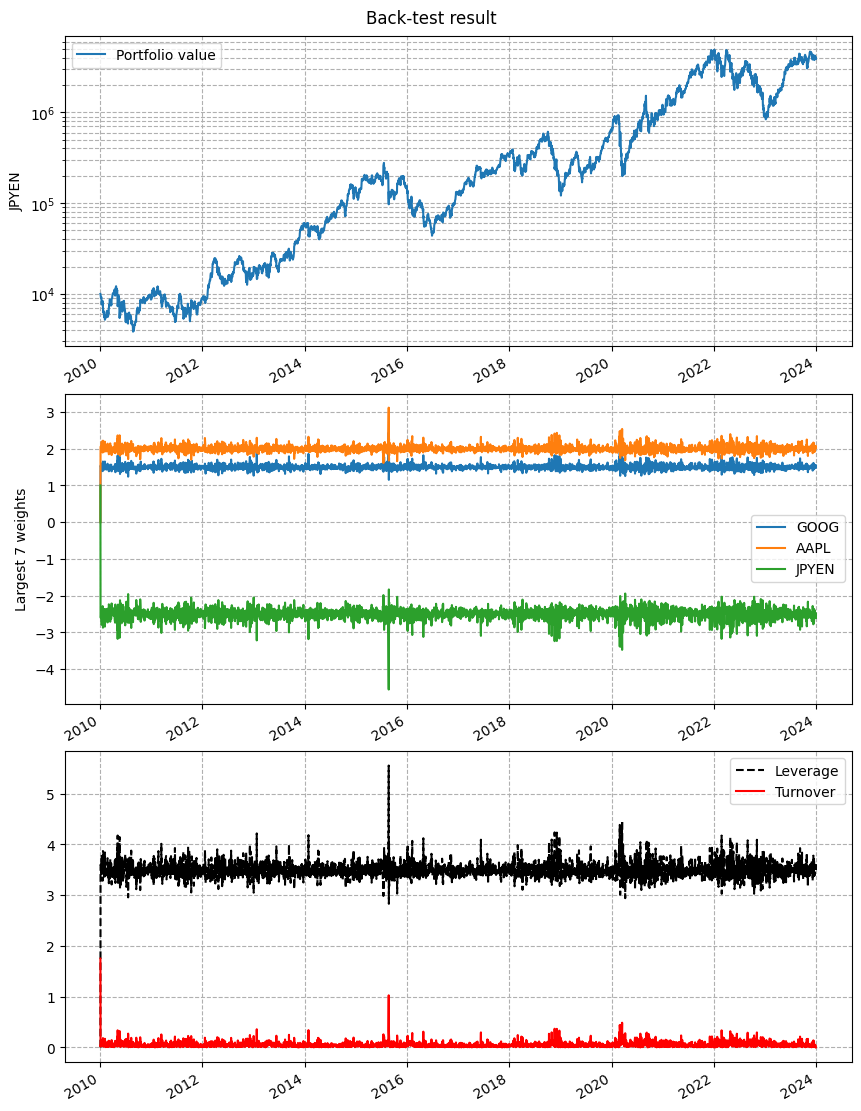

At time 2010-01-04 14:30:00+00:00, rebalancing to target weights!
At time 2010-01-13 14:30:00+00:00, rebalancing to target weights!
At time 2010-01-29 14:30:00+00:00, rebalancing to target weights!
At time 2010-03-12 14:30:00+00:00, rebalancing to target weights!
At time 2010-04-26 13:30:00+00:00, rebalancing to target weights!
At time 2010-05-05 13:30:00+00:00, rebalancing to target weights!
At time 2010-05-07 13:30:00+00:00, rebalancing to target weights!
At time 2010-05-21 13:30:00+00:00, rebalancing to target weights!
At time 2010-06-02 13:30:00+00:00, rebalancing to target weights!
At time 2010-06-30 13:30:00+00:00, rebalancing to target weights!
At time 2010-08-24 13:30:00+00:00, rebalancing to target weights!
At time 2010-09-20 13:30:00+00:00, rebalancing to target weights!
At time 2010-10-18 13:30:00+00:00, rebalancing to target weights!
At time 2011-02-15 14:30:00+00:00, rebalancing to target weights!
At time 2011-03-11 14:30:00+00:00, rebalancing to target weights!
At time 20

/Users/jacktang/miniconda3/envs/dev/lib/python3.11/site-packages/cvxportfolio/result.py:993: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show() # pragma: no cover


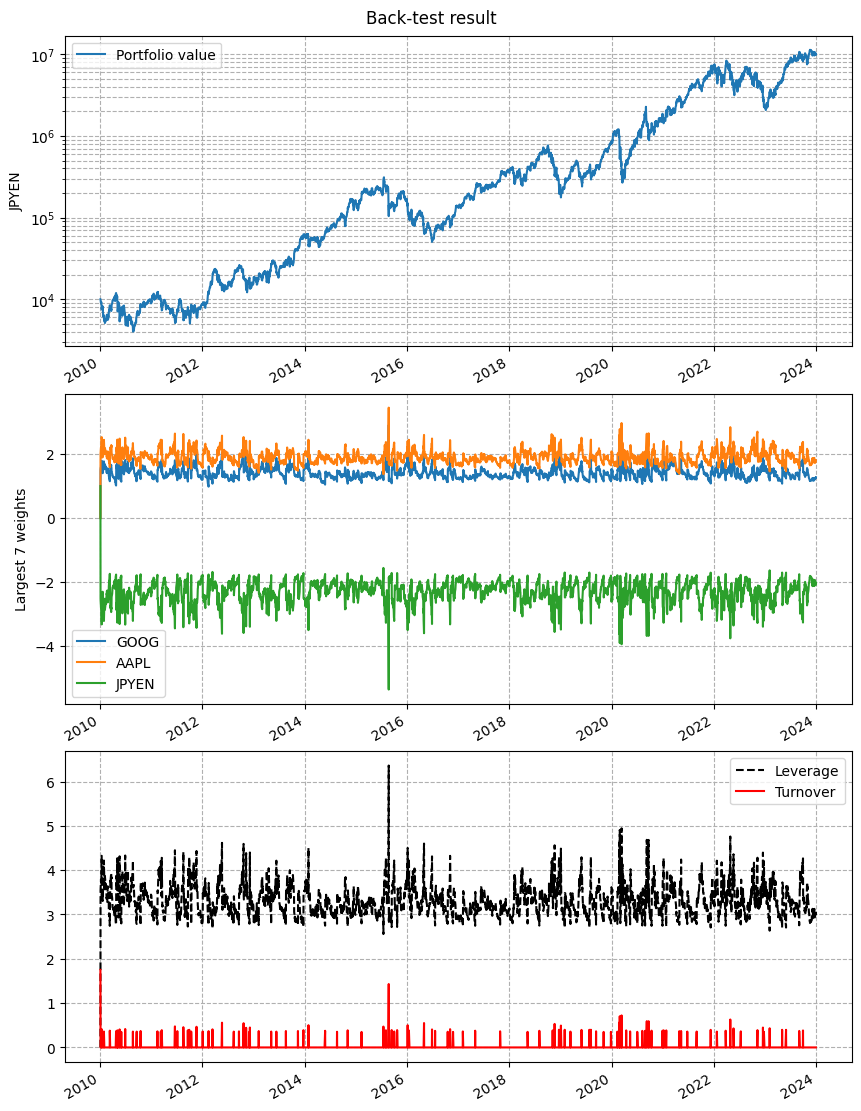

In [1]:
# https://github.com/andrewcz/cvxportfolio/blob/master/examples/leverage_margin_portfolio_bid_ask_modelling.py

"""This is a user-contributed example, and it's not finished.

*Work in progress.*

This example demonstrates how to use cvxportfolio to backtest a leveraged portfolio of US stocks
denominated in Japanese Yen (JPYEN). It compares three strategies:

1. Buy and hold: Purchase the target weights at the start and hold throughout the backtest period.
2. Rebalance every day: Rebalance the portfolio to the target weights at the end of each day.
3. Target rebalance leverage: Rebalance the portfolio to the target weights only when the leverage
   goes above a maximum threshold or below a minimum threshold.

The example also includes a custom cost model (StressModel) that adjusts the bid-ask spread based on
the volatility of the asset returns, increasing the spread during stressed market conditions.
"""

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cvxportfolio as cvx
from cvxportfolio.estimator import DataEstimator
from cvxportfolio.utils import set_pd_read_only


class StressModel(object):
    """A simple stress model that increases transaction costs (bid-ask spread) under certain conditions.

    The model calculates the bid-ask spread based on the volatility of the asset returns. If the
    volatility exceeds a specified threshold (stress_threshold), the model considers it a stressed
    market condition and increases the spread by a stress factor (stress_factor). Otherwise, the
    base spread (base_spread) is used.

    The transaction costs are assumed to be proportional to the absolute value of the trades (u).

    Parameters:
    - base_spread: The default bid-ask spread under normal market conditions (default: 0.001).
    - stress_factor: The factor by which the spread is increased under stressed conditions (default: 5).
    - stress_threshold: The volatility threshold above which the market is considered stressed (default: 0.02).
    """
    def __init__(self, base_spread=0.001, stress_factor=5, stress_threshold=0.02):
        self.base_spread = base_spread
        self.stress_factor = stress_factor
        self.stress_threshold = stress_threshold

    def get_bid_ask_spread(self, returns):
        """Calculate the bid-ask spread based on the volatility of the returns.

        If the volatility is above a certain threshold, it's considered a stress condition,
        and the spread is increased by the stress factor.
        """
        volatility = returns.std()
        is_stressed = volatility > self.stress_threshold
        spread = self.base_spread * (self.stress_factor if is_stressed else 1)
        return spread

    def simulate(self, t, u, h_plus, past_volumes,
                 past_returns, current_prices,
                 current_weights, current_portfolio_value, **kwargs):
        """Overriding the simulate function to include the stress-adjusted transaction costs."""
        spread = self.get_bid_ask_spread(past_returns.iloc[-1])
        transaction_costs = spread * np.abs(u)  # Assuming proportional to the trade size
        return transaction_costs.sum()


# Subclass of DownloadedMarketData to represent US (only) stocks in JPYEN
class ForeignCurrencyMarketData(cvx.DownloadedMarketData):
    """Represent US stocks/ETF returns, prices, and volumes in a foreign ccy.

    Supported currencies are EURO, JPYEN, GBPOUND (the currently supported
    cash keys other than USDOLLAR).

    In the future, the default MarketData servers will be able to handle
    currency conversion, using a similar mechanism as prototyped here.

    :param universe: Yahoo Finance tickers of **US assets only**.
    :type universe: iterable
    :param datasource: For this prototype only YahooFinance.
    :type datasource: str
    :param cash_key: EURO, GBPOUND, or JPYEN
    :type cash_key: str
    """
    def __init__(
            self, universe=(), datasource='YahooFinance', cash_key='JPYEN',
            *args, **kwargs):

        assert cash_key in ['JPYEN', 'EURO', 'GBPOUND']

        # creates returns, prices, volumes dataframes
        super().__init__(universe=universe, datasource=datasource,
            cash_key=cash_key, *args, **kwargs)

        rate = self._get_exchange_rate()
        rate_return = rate.pct_change().shift(-1)

        # the cash column of returns is already in cash_key
        orig_interest_rate = self.returns.iloc[:, -1]

        self.returns = (
            1 + self.returns).multiply((1 + rate_return), axis=0) - 1
        self.returns.iloc[:, -1] = orig_interest_rate
        self.returns = set_pd_read_only(self.returns)

        self.prices = set_pd_read_only(self.prices.multiply(rate, axis=0))
        self.volumes = set_pd_read_only(self.volumes.multiply(rate, axis=0))

    def _get_exchange_rate(self):
        mapping = {'JPYEN': 'JPY=X', 'EURO': 'EUR=X', 'GBPOUND': 'GBP=X'}

        # fx rate is timestamped 0:00 UTC (~midnight London)
        rate_full = cvx.YahooFinance(mapping[self.cash_key]).data

        # take close from day before rather than open, seems cleaner
        rate = rate_full.close.shift(1)

        # reindex, taking last available one
        return rate.reindex(self.returns.index, method='ffill')

class LeverageAdjustedFixedWeights(cvx.policies.Policy):
    def __init__(self, target_weights, max_leverage=4.2, min_leverage=2.8): #, target_leverage=3.5):#, #margin_call_leverage=6.0):
        self.target_weights = DataEstimator(target_weights, data_includes_cash=True)
        self.max_leverage = DataEstimator(max_leverage)
        self.min_leverage = DataEstimator(min_leverage)
        #self.target_leverage = DataEstimator(target_leverage)
        # self.margin_call_leverage = margin_call_leverage

    def _rescale_weights_to_target(self, weights, scale_factor):
        lev = current_leverage = sum(abs(current_weights.iloc[:-1]))

    def values_in_time(self, t, current_weights, current_portfolio_value, **kwargs):
        # Calculate the current leverage
        current_leverage = sum(abs(current_weights.iloc[:-1]))

        # If leverage is out of bounds, trade to target weights
        if (current_leverage > self.max_leverage.current_value) or (
                current_leverage < self.min_leverage.current_value):
            print(f'At time {t}, rebalancing to target weights!')
            return self.target_weights.current_value

        return current_weights

# Define the target weights and initial holdings
# This has leverage 3.5


target_weights = pd.Series({'AAPL': 2, 'GOOG': 1.5, 'JPYEN': -2.5})
initial_holdings = pd.Series({'AAPL': 0, 'GOOG': 0, 'JPYEN': 10000})

simulator = cvx.MarketSimulator(
    market_data=ForeignCurrencyMarketData(['AAPL', 'GOOG']),
    costs=[StressModel()]
    )


buy_and_hold = simulator.backtest(
    cvx.Hold(),
    pd.Timestamp('2010-01-01'),
    pd.Timestamp('2023-12-31'),
    h = target_weights * sum(initial_holdings))

print('BUY AND HOLD')
print(buy_and_hold)
buy_and_hold.plot()
plt.show()

rebalance_every_day = simulator.backtest(
    cvx.FixedWeights(target_weights),
    pd.Timestamp('2010-01-01'),
    pd.Timestamp('2023-12-31'),
    h = initial_holdings)

print('REBALANCE EVERY DAY')
print(rebalance_every_day)
rebalance_every_day.plot()
plt.show()

target_rebalance_leverage = simulator.backtest(
    LeverageAdjustedFixedWeights(target_weights),
    pd.Timestamp('2010-01-01'),
    pd.Timestamp('2023-12-31'),
    h = initial_holdings)


print('TARGET REBALANCE LEVERAGE')
print(target_rebalance_leverage)
target_rebalance_leverage.plot()
plt.show()